#### *Analyze a family of RNNs all trained on the same data but with different hyperparameters.*

Essentially, most RNNs fit the muscle activity data (EMG) with almost the same loss.

(This is a very easy task from an ML standpoint.)

But not all such RNNs are equivalent as RNNs are overparametrized, and their internal behavior depends on hyperparameters. Here we investigate this dependence.

The cost function for the RNN
$$ \sum_{t,c}\|\hat{y}(t,c) - y(t,c)\|_2^2 + \lambda_1\|A\|_F^2 + \lambda_2\|C\|_F^2,$$
where $A$ and $C$ are the state-to-state and state-to-output matrices, respectively.

The RNN hyperparameters,
- $\lambda_1$
- $\lambda_2$
- $\sigma_w$ (std dev of noise injected into neurons during training

are compared against various measures of RNN activation trajectories
- mean curvature
- mean curvature (path length normalized)
- mean torsion (generalized curvature)
- trajectory "tangling" (a "global measure of curvature")
- path length
- dimensionality (participation ratio)
- average of the norms of the Jacobian evaluated at all path points
- "noise robustness"
- "structural robustness"

The latter two measures are obtained by resimulating the RNN and injecting noise to the state variables (noise robustness) or by adding a random perturbation to $A$ (structural robustness) and then finding the strength of noise required to drop the EMG fit to $R^2< 0.5$. This is tricky because a small perturbation in $A$ can result in EMG fits that are qualitiatively good but quantitatively bad (e.g. small frequency changes might result in a huge drop in $MSE$). Thus we use dynamic time warping as a measure of loss instead of $MSE$.

----------

### TODO
Do:
- Test for 1 condition only
- Lie stuff -- lie bracket, lie derivatives, etc
- regularize the RNN activations maybe
- normalize by path length for curvature calculations
- check to make sure dtw is working correctly

# 0. Initial stuff

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [132]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn.grid_search import ParameterGrid # deprecation warning... 
from sklearn import decomposition
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

# For jupyter tensorboarding
from io import BytesIO
from functools import partial
import PIL.Image
from ipywidgets import FloatProgress

from IPython.display import clear_output, Image, display, HTML

import pickle
import os
import pprint as pp

from cycling_rnn import *

from dtw import dtw
from cdtw import pydtw

from tqdm import tqdm # progress bar

In [3]:
# sns colormaps
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
sns.set_palette(cmap)
sns.set_context('paper', font_scale=1.5)

# 0.1. Wrapper script
For testing individual simulations as opposed to loading from a `RUN` set

In [69]:
# From the wrapper script -- set user inputs
CUR_RUN = 'test1'
i = 1

In [21]:
param_grid = {}

param_grid['activation']    = np.random.choice(['tanh'], size=1)
param_grid['beta1']         = 10**np.random.uniform(-7, -3, size=1)
param_grid['beta2']         = 10**np.random.uniform(-5, -2, size=1)
param_grid['stddev_state']  = 10**np.random.uniform(-5, -1, size=1)
param_grid['stddev_out']    = 10**np.random.uniform(-4, 0, size=1)
param_grid['monkey']        = np.random.choice(['D'], size=1)
param_grid['num_neurons']   = np.array([100]).astype(int)

# Split param_grid to search along hyperparameter axes only
cur_params = ParameterGrid(param_grid)[0]
#param_grid = parameter_grid_split(param_grid)

# Fixed parameters
LEARNING_RATE = 0.0003
NUM_ITERS = 1000
LOAD_PREV = False
PREV_PATH = None
LOCAL_MACHINE = True

if LOCAL_MACHINE:
  PATH_PREFIX = '/Users/jeff/Documents/Python/_projects/cyclingRNN/'
else:
  PATH_PREFIX = '/vega/zmbbi/users/jss2219/cyclingRNN/'

NPSAVE_PATH = PATH_PREFIX+'saves/'+CUR_RUN+'/npsaves/'
TFSAVE_PATH = PATH_PREFIX+'saves/'+CUR_RUN+'/tfsaves/'
MLSAVE_PATH = PATH_PREFIX+'saves/'+CUR_RUN+'/mlsaves/'
TB_PATH = PATH_PREFIX+'saves/'+CUR_RUN+'/tb/'

def make_dir(path):
  """
    like os.makedirs(path) but avoids race conditions
  """
  try:
    os.makedirs(path)
  except OSError:
    if not os.path.isdir(path):
      raise

make_dir(NPSAVE_PATH)
make_dir(TFSAVE_PATH)
make_dir(MLSAVE_PATH)

# save param-grid (split version)
pickle.dump(cur_params, open(NPSAVE_PATH+str(i)+'params.pickle', 'wb'))

print 'Current Run: '+CUR_RUN

# Run rnn
print cur_params

if LOAD_PREV:
  load_model_path = PATH_PREFIX+'saves/'+PREV_PATH+'/tfsaves/'+str(i)
else:
  load_model_path = None

Y_TF, X_TF = run_rnn(monkey=cur_params['monkey'],
                     beta1=cur_params['beta1'],
                     beta2=cur_params['beta2'],
                     stddev_state=cur_params['stddev_state'],
                     stddev_out=cur_params['stddev_out'],
                     activation=cur_params['activation'],
                     num_neurons=cur_params['num_neurons'],
                     learning_rate=LEARNING_RATE,
                     num_iters=NUM_ITERS,
                     load_prev=LOAD_PREV,
                     save_model_path=TFSAVE_PATH+str(i),
                     load_model_path=load_model_path,
                     tb_path=TB_PATH+str(i),
                     local_machine=LOCAL_MACHINE)

np.save(NPSAVE_PATH+str(i)+'y', Y_TF)
np.save(NPSAVE_PATH+str(i)+'x', X_TF)
sio.savemat(MLSAVE_PATH+str(i)+'.mat', mdict={'X': X_TF, 'Y': Y_TF, 'params': cur_params})

Current Run: test1
{'monkey': 'D', 'num_neurons': 100, 'stddev_out': 0.00083486244157021086, 'stddev_state': 0.0045057478252982196, 'activation': 'tanh', 'beta2': 1.0786131608469733e-05, 'beta1': 0.00029236672629384181}
RNN/TensorArrayPack:0
  iter: 0000   Loss: 0.147862
  iter: 0500   Loss: 0.029681
  iter: 1000   Loss: 0.014385
  Finished


# 0.2. Load data from the simulation

In [79]:
RUN = './saves/test1/'

In [80]:
sim = i # should be the same as 'i' above. 
cur_params = pickle.load(open(RUN+'npsaves/'+str(sim)+'params.pickle', 'rb'))
pp.pprint(cur_params)

{'activation': 'tanh',
 'beta1': 0.00029236672629384181,
 'beta2': 1.0786131608469733e-05,
 'monkey': 'D',
 'num_neurons': 100,
 'stddev_out': 0.00083486244157021086,
 'stddev_state': 0.0045057478252982196}


In [82]:
# List directory
# Number of sims in RUN
total_sims = len([i for i in os.listdir(RUN+'tb') if i!='.DS_Store'])

# load x and y data
x = np.load(RUN+'npsaves/'+str(sim)+'x.npy')
y = np.load(RUN+'npsaves/'+str(sim)+'y.npy')
#os.listdir(RUN+'npsaves')

Get truncated input/output data

In [83]:
# build input and output data
if cur_params['monkey']=='D':
  data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb_processed.mat')
else:
  data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/cousFeb_processed.mat')
    
emg = data['EMG']
m1 = data['M1']
u_full, emg_full = get_full_data(cur_params)
x_trunc = x[:emg.shape[0], :emg.shape[1], :]
y_trunc = y[:emg.shape[0], :emg.shape[1], :]
u_trunc = create_input_array(y_trunc.shape)

In [84]:
stddev_struct = 0.00
stddev_state = 0.00
u_data, y_data = get_full_data(cur_params)
x_hat, y_hat, loss = get_noise_sim(stddev_struct, stddev_state, RUN, sim, y_data, u_data)

Get augmented input/output data.

Inefficient implementation. Just copying from the `run_rnn` function.

# 0.3 Analyze the model

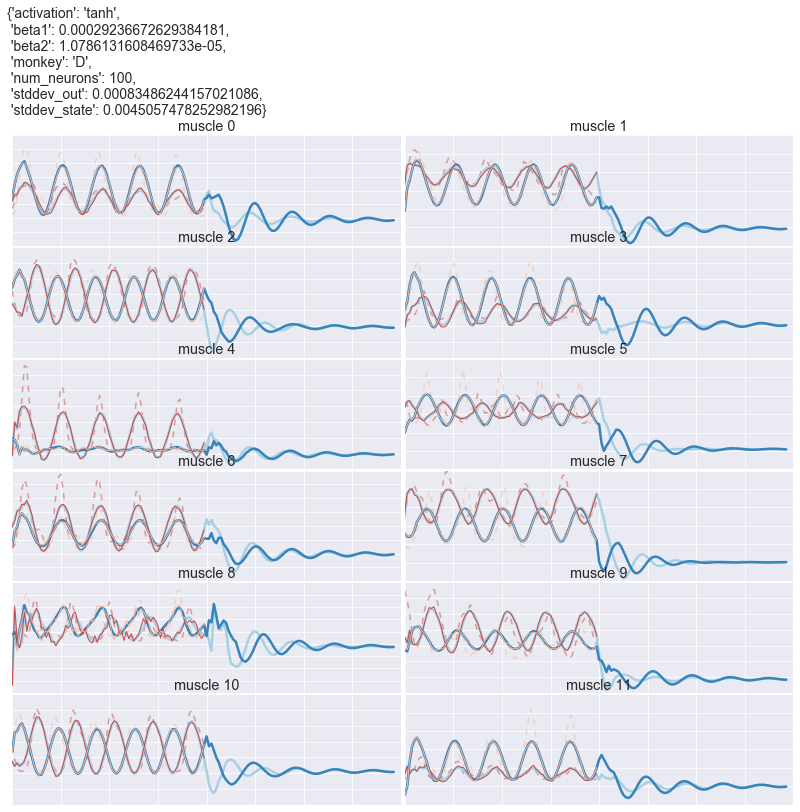

In [85]:
rows = 6
cols = 2

conds = [0, 2]

with sns.color_palette(n_colors=4):
    f, ax = plt.subplots(rows,cols, figsize=(14, 12), sharex=True, sharey=False,
                         subplot_kw={'xticklabels':[], 'yticklabels':[]},
                         gridspec_kw={'wspace':0.01, 'hspace':0.01})
    for i in range(rows):
        for j in range(cols):
            muscle = np.ravel_multi_index((i,j), (rows,cols))
            ax[i,j].plot(emg[:,conds,muscle], '--', linewidth=1.5, alpha=.5)
            ax[i,j].plot(y_hat[:,conds,muscle],'-',linewidth=2.5, alpha=1)
            ax[i,j].plot(y_trunc[:,conds,muscle],'-',linewidth=1, alpha=1)
            ax[i,j].set_title('muscle '+str(muscle))
f.suptitle(pp.pformat(cur_params), fontsize=14, x=0.12, y=0.92, verticalalignment='bottom', horizontalalignment='left')
plt.show()

-------

# Actual analysis starts here

-------

# 1. Geometric analyses

In [229]:
def tangling(signal_in, alpha=0.1, dt = 0.025):
  '''
    signal_in: (T, batch_size, n) 
    tangling analysis from abby
  '''
  sig_diff = np.diff(signal_in, axis=0)
  signal_in = signal_in[1:, :, :]
  Q = np.zeros(signal_in.shape[:2])
  const = alpha*np.sum(np.var(signal_in, axis=(0,1))) # var across all data, or var across one axis then sum?
  for t in range(signal_in.shape[0]):
    for b in range(signal_in.shape[1]):
      num = np.sum((sig_diff[t, b, :]/dt - sig_diff/dt)**2, axis=2)
      den = np.sum((signal_in[t, b, :] - signal_in)**2, axis=2) + const
      Q[t, b] = np.max(num/den)
  return Q

def percent_tangling(m1_in, emg_in):
  """
    scalar summary of tangling() results
    percent tangling, i.e. percentage of points above the y=x line
  """
  q_emg = tangling(emg_in)
  q_m1 = tangling(m1_in)
  ratio = q_m1/q_emg
  return np.true_divide(np.sum(ratio > 1), ratio.size)

def mean_tangling(m1_in):
  """
    scalar summary of tangling() results
    mean tangling, i.e. just the mean...
  """
  return np.mean(tangling(m1_in))
  
def mean_curvature_osculating(signal_in):
  """
    mean curvature based on get_curvature() function
  """
  C = signal_in.shape[1]
  k = np.zeros(signal_in.shape[:-1])
  for c in range(C):
    k[:, c] = get_curvature(signal_in[:, c, :])
  k[k==0] = np.nan
  return np.nanmean(k, axis=(0,1))
  
def mean_curvature(signal_in, total_points=11, deg=4, normalize=False):
  """
    mean curvature based on get_generalized_curvature() function
  """
  C = signal_in.shape[1]
  k = np.zeros(signal_in.shape[:-1]+(deg-1,))
  for c in range(C):
    k[:, c, :], _ = get_generalized_curvature(signal_in[:, c, :], total_points, deg)
  if normalize:
    k = k/get_path_length(signal_in, filt_freq=0.3)[np.newaxis, :, np.newaxis]
  k[k==0] = np.nan
  return np.nanmean(k, axis=(0,1))

def get_participation_ratio(signal_in):
  """
    Participation ratio is an approximate measure of dimensionality.
    PR = sum(evs)**2/sum(evs**2)
    where evs are the eigenvalues of the covariance matrix of signal_in
    signal_in is shape (T, batch_size, n), which is reshaped to (T*batch_size, n)
    the covariance matrix is size (n, n)
  """
  signal_in = np.reshape(signal_in, [-1, signal_in.shape[-1]], order='F')
  Cov = np.cov(signal_in.T)
  eigvals = np.linalg.eigvals(Cov)
  return np.sum(eigvals)**2/np.sum(eigvals**2)

def tanh(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
def dtanh(x):
  ''' derivative of tanh() '''
  return 1. - tanh(x)**2

def get_jacobian(sim):
  """
    get the jacobian matrix of the RNN
    output: J, a function that takes x, u as vector inputs and returns the jacobian evaluated at those points
  """
  # get A, B
  TF_PATH = RUN+'tfsaves/'+str(sim)
  tf.reset_default_graph()
  with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(TF_PATH+'.meta')
    new_saver.restore(sess, TF_PATH)
    # Get Mat variable
    Mat = sess.run([v for v in tf.all_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'][0])
    A = Mat[2:]
    B = Mat[:2]
  def J(x, u):
    return np.dot(A, np.diag(dtanh(np.dot(A.T, x) + np.dot(B.T, u))))
  return J

def get_sum_of_jacobians(sim, x_in, u_in, norm='fro', squared=True):
  """
    get the jacobian and evaluate it at every point in x_in (T, batch_size, n).
    take the norm of the jacobian using `norm` (use 'trace' to caculate divergence)
    average across T and batch_size.
  """
  J = get_jacobian(sim)
  R = 0
  for t in range(x_in.shape[0]):
    for c in range(x_in.shape[1]):
      J_ = J(x_in[t, c, :], u_in[t, c, :])
      if norm == 'trace':
        R_ = np.trace(J_)
      else:
        R_ = np.linalg.norm(J_, norm)
      if squared:
        R_ = R_**2 
      R += R_
  R = np.true_divide(R, np.prod(x_in.shape[:2]))
  return R



# 2. Hyperparameter analyses

In [230]:
# signal errors
def r2_sigerr(x, y):
  """ R_squared of two signals"""
  err = metrics.r2_score(np.reshape(y, [-1, y.shape[-1]]),
                         np.reshape(x, [-1, x.shape[-1]]), multioutput='uniform_average')
  return err

def mse_sigerr(x, y):
  """ MSE of two signals """
  return np.mean((x - y)**2)

# Rpy2 stuff
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
# Set up our R namespaces
R = rpy2.robjects.r
DTW = importr('dtw')
def dtw_sigerr_R(x, y):
  """ dynamic time warping error (R package) """
  dist = []
  idx1 = []
  idx2 = []
  for c in range(x.shape[1]):
    alignment = R.dtw(np.squeeze(x[:, c, :]), np.squeeze(y[:, c, :]), keep=False, window='none', step=DTW.asymmetric)
    dist.append(alignment.rx('distance')[0][0])
    idx1.append(np.array(alignment.rx('index1')[0]).astype('int')-1)
    idx2.append(np.array(alignment.rx('index2')[0]).astype('int')-1)
  #Now get R2
  x_ = []
  y_ = []
  for c in range(x.shape[1]):
    x_.append(x[path[c][0], c, :])
    y_.append(y[path[c][1], c, :])
  x_ = np.concatenate(x_)
  y_ = np.concatenate(y_)
  err = r2_sigerr(x_, y_)
  return np.mean(dist), err

def dtw_sigerr_P(x, y):
  """ dynamic time warping error (python package) """
  def mydist(x, y):
    return np.linalg.norm(x-y, ord=np.inf)
  dist = []
  path = []
  for c in range(x.shape[1]):
    dist_, cost, acc, path_ = dtw(np.squeeze(x[:,c,:]), np.squeeze(y[:,c,:]), dist=mydist)
    dist.append(dist_)
    path.append(path_)
  
  x_ = []
  y_ = []
  for c in range(x.shape[1]):
    x_.append(x[path[c][0], c, :])
    y_.append(y[path[c][1], c, :])
  x_ = np.concatenate(x_)
  y_ = np.concatenate(y_)
  err = r2_sigerr(x_, y_)
  return np.mean(dist), err


In [384]:
def get_full_data(cur_params):
  """
    returns u_data, y_data for tensorflow's feed_dict.
  """
  path_prefix = '/Users/jeff/Documents/Python/_projects/cyclingRNN/'
  if cur_params['monkey']=='D':
    data = sio.loadmat(path_prefix+'drakeFeb.mat')
  else:
    data = sio.loadmat(path_prefix+'cousFeb.mat')

  # Built augmented data
  emg2 = preprocess_array(data['D'][0, 0]['EMG'])
  time_axis, time_inds1, time_inds2 = get_time_axis(data['D'][0, 0]['KIN'])
  y_data1 = emg2[time_axis]
  p = y_data1.shape[-1]

  # Build inputs
  m = 2
  u_data1 = create_input_array(y_data1.shape)

  # Augmented data
  # For regularizing the network -- it must fit actual and augmented data
  period = int(np.round(np.diff(time_inds2).mean()))
  y_cat1 = augmented_data(emg2, time_inds1, period=period, tiles=10)
  y_cat1 = y_cat1[::25]
  y_cat2 = augmented_data(emg2, time_inds2, period=period, tiles=10)
  y_cat2 = y_cat2[::25]

  u_cat1 = create_input_array(y_cat1.shape)
  u_cat2 = create_input_array(y_cat2.shape)

  sequence_length = [y_data1.shape[0], y_cat1.shape[0], y_cat2.shape[0]]
  y_data = np.zeros((np.max(sequence_length), 4*3, p))
  u_data = np.zeros((np.max(sequence_length), 4*3, m))

  y_data[:sequence_length[0], 0:4, :] = y_data1
  y_data[:sequence_length[1], 4:8, :] = y_cat1
  y_data[:sequence_length[2], 8:12, :] = y_cat2

  u_data[:sequence_length[0], 0:4, :] = u_data1
  u_data[:sequence_length[1], 4:8, :] = u_cat1
  u_data[:sequence_length[2], 8:12, :] = u_cat2
  return u_data, y_data

def mean_squared_error(x, y):
  return np.mean((x - y)**2)

def get_noise_sim(stddev_struct, stddev_state, RUN, sim, y_data, u_data):
  """
    loads TF model. Then simulates it again, but with noise
    stddev_struct: std dev of structural perturbation on weight matrix
    stddev_state: std dev of additive noise to each neuron
    RUN: directory of the current run
    sim: integer for the simulation
    y_data, u_data: reference data for feed_dict
  """
  TF_PATH = RUN+'tfsaves/'+str(sim)
  tf.reset_default_graph()
  with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(TF_PATH+'.meta')
    new_saver.restore(sess, TF_PATH)
    # Get Mat variable
    Mat = sess.run([v for v in tf.all_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'][0])
    A = Mat[2:]
    B = Mat[:2]
    newMat = np.zeros(Mat.shape)
    newMat[:2] = B
    newMat[2:] = A + stddev_struct*np.random.randn(A.shape[0], A.shape[1])
    sess.run([v for v in tf.all_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'][0].assign(newMat))
    feed_dict = {'Y:0': y_data, 'U:0': u_data, 'stddev_state:0': stddev_state}
    y_hat, x_hat, loss = sess.run(['Y_hat:0', 'RNN/TensorArrayPack:0', 'cost1:0'], feed_dict)
  return x_hat, y_hat, loss

def get_noise_robustness(sim, y_data, u_data, conds, err_f=mse_sigerr, dtw_err=False, num=50):
  """
    gradually increases noise until error (R squared) drops below 0.5
    tests for both state noise robustness as well as structural robustness
    - state noise robustness: noise of strength sdtdev_state injected into neurons during simulation
    - structural robustness: apply a single noisy perturbation to the matrix A then simulate
    sim: int. which simulation to use.
    y_data, u_data: reference data for feed_dict
    num: input for np.logspace(), number of stddevs...
  """
  err = []
  
  for stddev_state in tqdm(np.logspace(-3, 1, num=num), desc='std dev state', leave=False):
    x_hat, y_hat, loss = get_noise_sim(0, stddev_state, RUN, sim, y_data, u_data)
    x_hat = x_hat[:emg.shape[0], conds, :]
    y_hat = y_hat[:emg.shape[0], conds, :]
    
    if dtw_err:
      dist, err = err_f(y_hat, emg[:, conds, :])
    else:
      err = err_f(y_hat, emg[:, conds, :])
    if err < 0.5:
      break
    
  for stddev_struct in tqdm(np.logspace(-4, 1, num=num), desc='std dev struct', leave=False):
    x_hat, y_hat, loss = get_noise_sim(stddev_struct, 0, RUN, sim, y_data, u_data)
    x_hat = x_hat[:emg.shape[0], conds, :]
    y_hat = y_hat[:emg.shape[0], conds, :]

    if dtw_err:
      dist, err = err_f(y_hat, emg[:, conds, :])
    else:
      err = err_f(y_hat, emg[:, conds, :])
    if err < 0.5:
      break
  
  return stddev_state, stddev_struct

# 3. Analyze

In [385]:
RUN = './saves/12-26-D/'

In [386]:
# List directory
# Number of sims in RUN
total_sims = len([i for i in os.listdir(RUN+'tb') if i!='.DS_Store'])
# Get monkey
cur_params = pickle.load(open(RUN+'npsaves/'+str(1)+'params.pickle', 'rb'))

print total_sims

100


In [387]:
# Get truncated input/output data
# build input and output data
if cur_params['monkey']=='D':
  data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb_processed.mat')
else:
  data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/cousFeb_processed.mat')

emg = data['EMG']
m1 = data['M1']
u_full, emg_full = get_full_data(cur_params)

In [388]:
def evaluate_run(conds):
  """
    Evaluate a RUN (all simulations) for a specified choice of conditions (conds)
  """

  params = []
  out_metrics = []
  
  f = FloatProgress(min=1, max=(total_sims+1))
  display(f)
  for sim in range(1,total_sims+1):
    f.value += 1
    cur_params = pickle.load(open(RUN+'npsaves/'+str(sim)+'params.pickle', 'rb'))
    x = np.load(RUN+'npsaves/'+str(sim)+'x.npy')
    y = np.load(RUN+'npsaves/'+str(sim)+'y.npy')
    # truncate to remove augmented data
    x_trunc = x[:emg.shape[0], :emg.shape[1], :]
    y_trunc = y[:emg.shape[0], :emg.shape[1], :]
    u_trunc = create_input_array(y_trunc.shape)

    # truncate conditions
    x_trunc = x_trunc[:, conds, :]
    y_trunc = y_trunc[:, conds, :]
    u_trunc = u_trunc[:, conds, :]

    emg_ = emg[:, conds, :]

    # get params
    params.append(cur_params)

    mets = dict()
    mets['percent tangling'] = percent_tangling(x_trunc,emg_) # note condition truncation on emg
    mets['mean tangling'] = mean_tangling(x_trunc)
    mets['path length'] = np.sum(get_path_length(x_trunc, filt_freq=0.3))
    mets['mean curvature osc'] = mean_curvature_osculating(x_trunc)
    mets['mean curvature 1'] = mean_curvature(x_trunc, total_points=11, deg=4)
    mets['mean curvature 2'] = mean_curvature(x_trunc, total_points=21, deg=8)
    mets['mean curvature 3'] = mean_curvature(x_trunc, total_points=11, deg=4, normalize=True)
    mets['mean curvature 4'] = mean_curvature(x_trunc, total_points=21, deg=8, normalize=True)
    mets['jacobians 1'] = get_sum_of_jacobians(sim, x_trunc, u_trunc, 'fro')
    mets['jacobians 2'] = get_sum_of_jacobians(sim, x_trunc, u_trunc, 2, squared=False)
    mets['jacobians 3'] = get_sum_of_jacobians(sim, x_trunc, u_trunc, 'trace', squared=False)
    mets['jacobians 4'] = get_sum_of_jacobians(sim, x_trunc, u_trunc, 'trace', squared=True)
    mets['PR'] = get_participation_ratio(x_trunc)
    mets['MSE'] = metrics.mean_squared_error(np.reshape(emg_, [-1,emg_.shape[-1]]),
                                              np.reshape(y_trunc, [-1, y_trunc.shape[-1]]), multioutput='uniform_average') # condition truncation on emg
    mets['R2'] = metrics.r2_score(np.reshape(emg_, [-1, emg_.shape[-1]]),
                                  np.reshape(y_trunc, [-1, y_trunc.shape[-1]]), multioutput='uniform_average') # condition truncation on emg
    err_fun = r2_sigerr
    mets['noise robustness r2'], mets['struct robustness r2'] = get_noise_robustness(sim, emg_full, u_full,
                                                                               conds, err_fun, dtw_err=False, num=40)
    err_fun = dtw_sigerr_P
    mets['noise robustness dtw_p'], mets['struct robustness dtw_p'] = get_noise_robustness(sim, emg_full, u_full,
                                                                               conds, err_fun, dtw_err=True, num=40)
    out_metrics.append(mets)
    
  return params, out_metrics

In [389]:
def process_dataframe(params, out_metrics):
  # join params and metrics into one dataframe
  df = pd.DataFrame(params)
  metrics_df = pd.DataFrame(out_metrics)
  df = df.join(metrics_df)
  
  # remove outliers
  inds = df['MSE'] < df['MSE'].std()*3
  df = df[inds]

  # Split the generalized curvature columns into multiple columns, one for each curvature
  mc1 = df['mean curvature 1'].apply(pd.Series)
  mc2 = df['mean curvature 2'].apply(pd.Series)
  mc3 = df['mean curvature 3'].apply(pd.Series)
  mc4 = df['mean curvature 4'].apply(pd.Series)

  mc1.columns = ['mc1_'+str(i) for i in list(mc1.columns)]
  mc2.columns = ['mc2_'+str(i) for i in list(mc2.columns)]
  mc3.columns = ['mc3_'+str(i) for i in list(mc3.columns)]
  mc4.columns = ['mc4_'+str(i) for i in list(mc4.columns)]

  df = df.join(mc1)
  df = df.join(mc2)
  df = df.join(mc3)
  df = df.join(mc4)
  
  return df

In [390]:
#double check:
#conds 0,1 is fw, 2,3 is bw
#dtw is doing paths correctly...

In [ ]:
conds = [0, 1] # or [eval, 2, 3]
params, out_metric = evaluate_run(conds)
df1 = process_dataframe(params, out_metric)
pickle.dump(df1, open(RUN+'df1.pickle', 'wb'))

# conds = [2, 3]
# params, out_metric = evaluate_run(conds)
# df2 = process_dataframe(params, out_metric)
# pickle.dump(df2, open(RUN+'df2.pickle', 'wb'))

conds = [0, 1, 2, 3]
params, out_metric = evaluate_run(conds)
df3 = process_dataframe(params, out_metric)
pickle.dump(df3, open(RUN+'df3.pickle', 'wb'))

std dev struct:  22%|██▎       | 9/40 [00:15<00:51,  1.66s/it]

In [305]:
df = df1

In [306]:
# Display columns
df.columns

Index([u'activation', u'beta1', u'beta2', u'monkey', u'num_neurons',
       u'stddev_out', u'stddev_state', u'MSE', u'PR', u'R2', u'jacobians 1',
       u'jacobians 2', u'jacobians 3', u'jacobians 4', u'mean curvature 1',
       u'mean curvature 2', u'mean curvature 3', u'mean curvature 4',
       u'mean curvature osc', u'mean tangling', u'path length',
       u'percent tangling', u'mc1_0', u'mc1_1', u'mc1_2', u'mc2_0', u'mc2_1',
       u'mc2_2', u'mc2_3', u'mc2_4', u'mc2_5', u'mc2_6', u'mc3_0', u'mc3_1',
       u'mc3_2', u'mc4_0', u'mc4_1', u'mc4_2', u'mc4_3', u'mc4_4', u'mc4_5',
       u'mc4_6'],
      dtype='object')

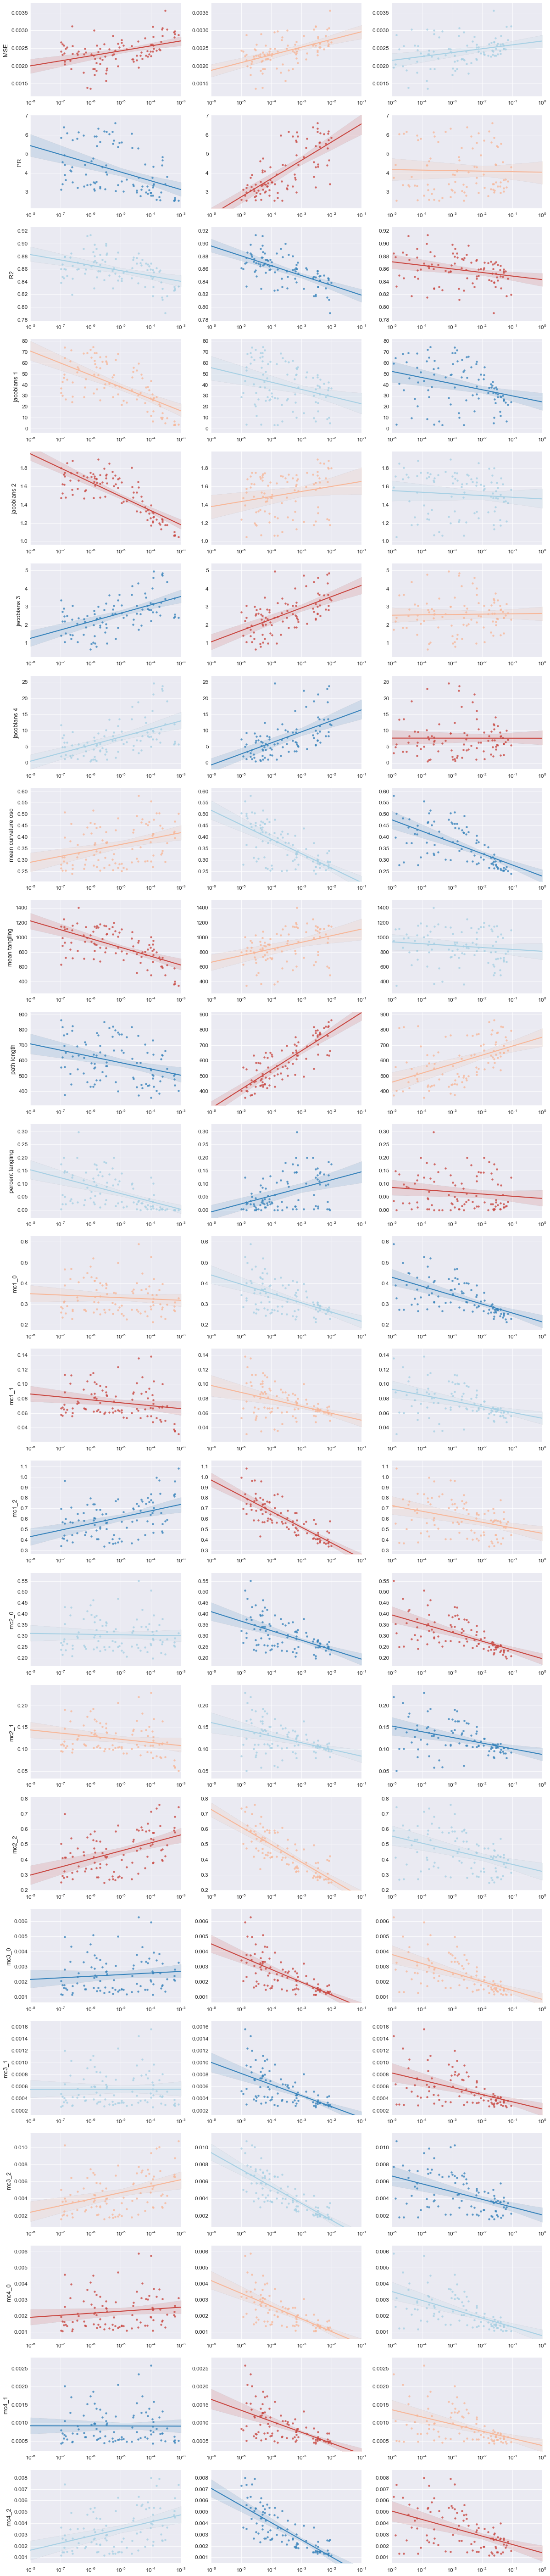

In [334]:
cols = [u'beta1', u'beta2', u'stddev_state']
rows = [u'MSE', u'PR', u'R2',
        u'jacobians 1', u'jacobians 2', u'jacobians 3', u'jacobians 4',
        u'mean curvature osc',
        u'mean tangling',
        u'path length',
        u'percent tangling',
        u'mc1_0', u'mc1_1', u'mc1_2',
        u'mc2_0', u'mc2_1', u'mc2_2',
        u'mc3_0', u'mc3_1', u'mc3_2',
        u'mc4_0', u'mc4_1', u'mc4_2']#,
        #'noise robustness', 'struct robustness']

num_cols = len(cols)
num_rows = len(rows)

f, ax = plt.subplots(num_rows, num_cols, figsize=(20,100), sharey=False, sharex=False)

for row in range(num_rows):
  for col in range(num_cols):
    ax[row, col].set(xscale='log')
    sns.regplot(cols[col], rows[row], df, logx=True, ax=ax[row, col], truncate=False)
    if row < num_rows:
      ax[row, col].xaxis.label.set_visible(False)
    if col > 0:
      ax[row, col].yaxis.label.set_visible(False)
      
    d_range = df[rows[row]].max() - df[rows[row]].min()
    ax[row, col].set_ylim([df[rows[row]].min()-0.1*d_range, df[rows[row]].max()+0.1*d_range])
    ax[row, col].set_xlim([df[cols[col]].min(), df[cols[col]].max()])

    # plot ref lines
    
    # get right xlim/ylim
      
plt.show()

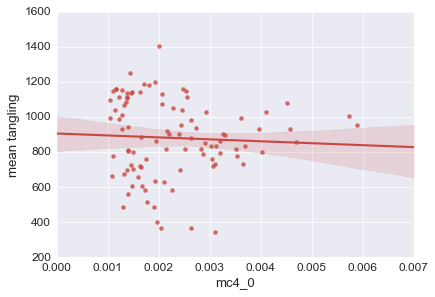

In [376]:
sns.regplot('mc4_0', 'mean tangling', df);

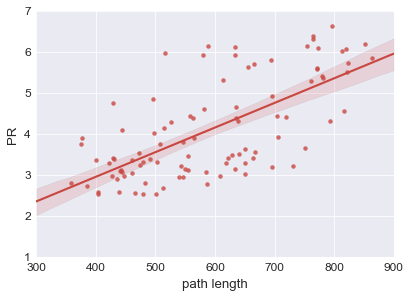

In [375]:
sns.regplot('path length', 'PR', df);

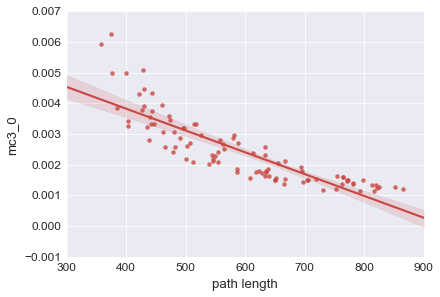

In [374]:
sns.regplot('path length', 'mc3_0', df);

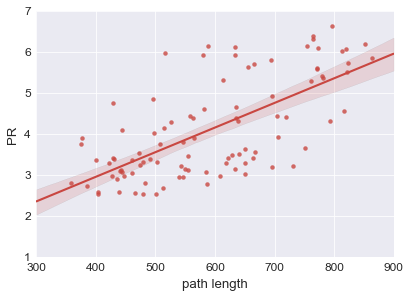

In [373]:
sns.regplot('path length', 'PR', df);

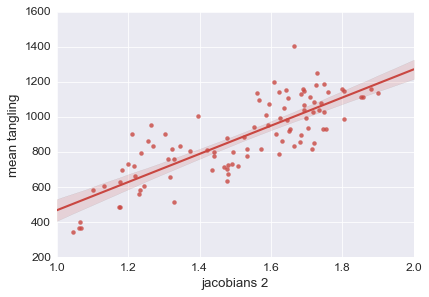

In [371]:
sns.regplot('jacobians 2', 'mean tangling', df);

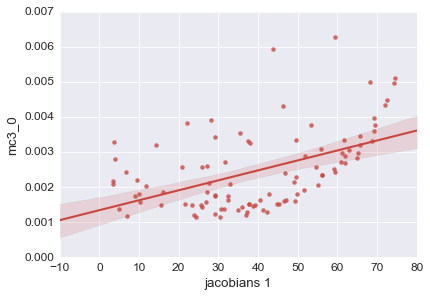

In [372]:
sns.regplot('jacobians 1', 'mc3_0', df);

In [ ]:
# analyze sum_of_jacobians & plot eig(J)
sim = 4

cur_params = pickle.load(open(RUN+'npsaves/'+str(sim)+'params.pickle', 'rb'))
x = np.load(RUN+'npsaves/'+str(sim)+'x.npy')
y = np.load(RUN+'npsaves/'+str(sim)+'y.npy')
# truncate to remove augmented data
x_trunc = x[:emg.shape[0], :emg.shape[1], :]
y_trunc = y[:emg.shape[0], :emg.shape[1], :]
u_trunc = create_input_array(y_trunc.shape)

r = get_sum_of_jacobians(sim, x_trunc, u_trunc)

J = get_jacobian(sim)
t = 50
c = 0
f = plot_eigs(J(x_trunc[t,c,:], u_trunc[t,c,:]))

# 4. Tensorboard

In [ ]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)